# Sinusoidal 
This notebook intends to demo inference in a univariate model defined as
\begin{equation}
    \begin{cases}
        Y_t = X_t + \beta W_t, \\
        \mathrm{d}X_t = \sin(X_t - \alpha) \mathrm{d}t + \sigma\mathrm{d}V_t, \\
        X_0 \sim \mathcal{N}(0, \sigma),
    \end{cases}
\end{equation}
where $\alpha, \beta, \sigma > 0$. We begin importing necessary packages for defining the model and get (using Euler-Maruyama)

In [1]:
from pyfilter.timeseries import StateSpaceModel, EulerMaruyma, Observable, LinearGaussianObservations

Next, we define a model where we let $(\beta, \alpha, \sigma) \triangleq (0.25, \pi, 1)$.

In [2]:
import numpy as np
from torch.distributions import Normal, Uniform, Exponential, Gamma
import torch
from math import pi


def fh0(alpha, sigma):
    return 0.


def gh0(alpha, sigma):
    return sigma


def fh(x, alpha, sigma):
    return torch.sin(x - alpha)


def gh(x, alpha, sigma):
    return sigma


sinus = EulerMaruyma((fh0, gh0), (fh, gh), (pi, 1.), (Normal(0., 1.), Normal(0., 1.)), dt=1e-2)
simmodel = LinearGaussianObservations(sinus, 1., 0.25)

In order to perform inference, we sample some data and get

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 9))

predictions = 40

x, y = simmodel.sample(1000 + predictions)

x = x.numpy()
y = y.numpy()

ax.plot(y, label='Observable')
ax.plot(x, 'r--', alpha=0.75, label='Hidden')

plt.legend()

We then define a model again where we set the priors to use

In [4]:
sinus = EulerMaruyma((fh0, gh0), (fh, gh), (Gamma(4, 1), Exponential(1)), (Normal(0., 1.), Normal(0., 1.)), dt=1e-2)

ssm = LinearGaussianObservations(sinus, 1., Exponential(1))

Next, we choose the inference algorithm. As the observed noise process is additive in terms of the noise, we choose the UKF to target the state, and NESS to target the parameters.

In [ ]:
from pyfilter.algorithms import NESSMC2
from pyfilter.filters import SISR
import time
import torch

algs = list()

y = torch.tensor(y)

for i in range(4):
    filt = SISR(ssm.copy(), 400)
    
    algs.append(
        NESSMC2(filt, 1000).initialize().fit(y[:-predictions])
    )

NESSMC2:   2%|█▍                                                                     | 21/1000 [00:04<03:21,  4.85it/s]

Next, we plot the filtered component on the actual

TypeError: sum() received an invalid combination of arguments - got (axis=int, out=NoneType, ), but expected one of:
 * ()
 * (torch.dtype dtype)
 * (tuple of ints dim, torch.dtype dtype)
      didn't match because some of the keywords were incorrect: axis, out
 * (tuple of ints dim, bool keepdim, torch.dtype dtype)
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: axis, out


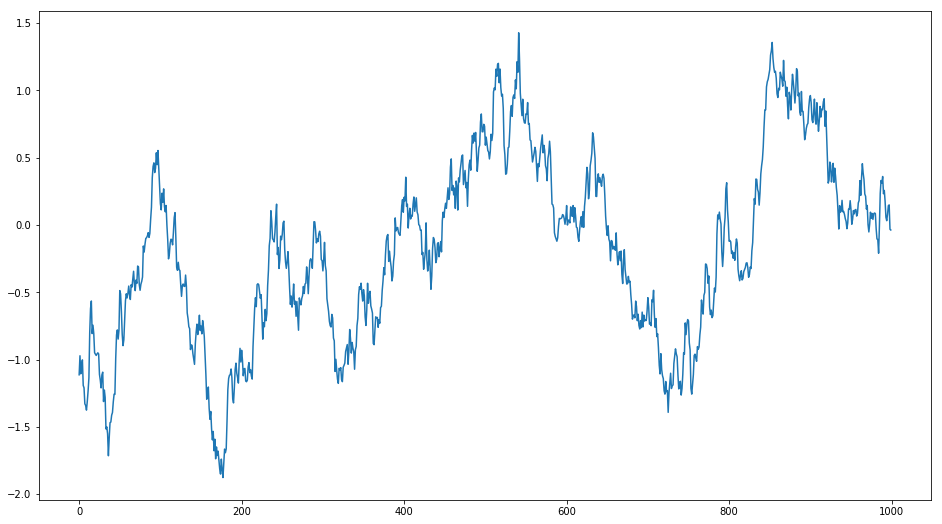

In [6]:
fig, ax = plt.subplots(figsize=(16, 9))

ax.plot(x[:-predictions], label='Actual hidden')
ax.plot(algs[0].filtermeans(), label='Filtered')

plt.legend()

We then plot the true parameters with the posteriors.

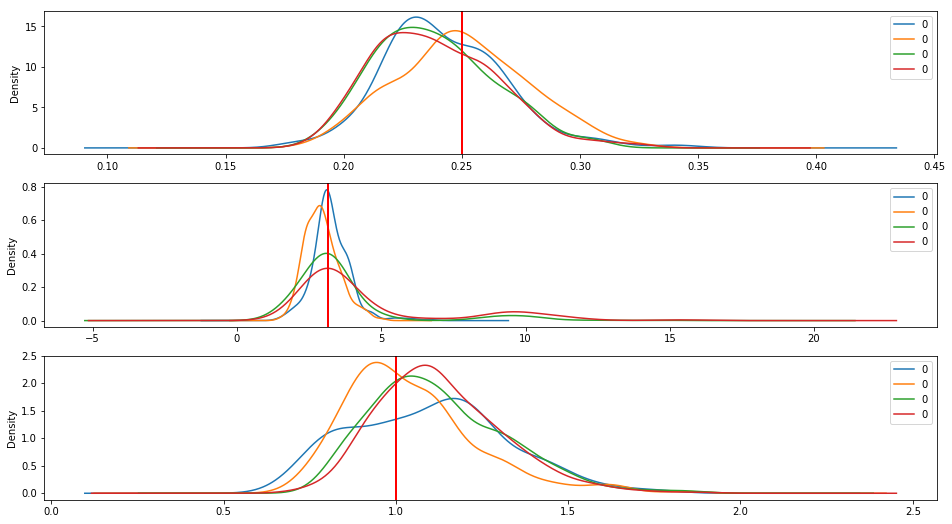

In [7]:
import pandas as pd


fig, ax = plt.subplots(3, figsize=(16, 9))

for alg in algs:
    pd.DataFrame(alg.filter.ssm.observable.theta[-1].values.numpy()).plot(kind='kde', ax=ax[0])
    ax[0].axvline(simmodel.observable.theta[-1].values, color='r')

    for i, (p, ptrue) in enumerate(zip(alg.filter.ssm.hidden.theta, simmodel.hidden.theta)):
        pd.DataFrame(p.values.numpy()).plot(kind='kde', ax=ax[i+1])
        ax[i+1].axvline(ptrue.values, color='r')

plt.show()